**SHAP Explainability Plots** \
_Author: Joaquín Torres Bravo_

### Libraries

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Legend
import matplotlib.colors as mcolors # Colormap
import seaborn as sns
from scipy.stats import zscore # Normalization

c:\Users\Joaquín Torres\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [ ]:
# Retrieve attribute names in order
attribute_names = attribute_names = list(np.load('../01-EDA/results/feature_names/all_features.npy', allow_pickle=True))

# Load test data
X_test_pre = np.load('../02-training_data_generation/results/pre/X_test_pre.npy', allow_pickle=True)
y_test_pre = np.load('../02-training_data_generation/results/pre/y_test_pre.npy', allow_pickle=True)
X_test_post = np.load('../02-training_data_generation/results/post/X_test_post.npy', allow_pickle=True)
y_test_post = np.load('../02-training_data_generation/results/post/y_test_post.npy', allow_pickle=True)

# Type conversion needed    
data_dic = {
    "X_test_pre": pd.DataFrame(X_test_pre, columns=attribute_names).convert_dtypes(),
    "y_test_pre": y_test_pre,
    "X_test_post": pd.DataFrame(X_test_post, columns=attribute_names).convert_dtypes(),
    "y_test_post": y_test_post,
}

In [2]:
method_names = {
    0: "ORIG",
    1: "ORIG_CW",
    2: "OVER",
    3: "UNDER"
}
model_choices = {
    "ORIG": "XGB",
    "ORIG_CW": "RF",
    "OVER": "XGB",
    "UNDER": "XGB"
}

# Load names of social and individual attributes
soc_var_names = np.load('../01-EDA/results/feature_names/social_factors.npy', allow_pickle=True)
ind_var_names = np.load('../01-EDA/results/feature_names/individual_factors.npy', allow_pickle=True)
# Retrieve attribute names in order
attribute_names = attribute_names = list(np.load('../01-EDA/results/feature_names/all_features.npy', allow_pickle=True))

### SHAP Plots

In [ ]:
method_name = 'OVER'

plt.figure(figsize=(35, 75))
for i, group in enumerate(['pre', 'post']):
            X_test = data_dic['X_test_' + group]
            y_test = data_dic['y_test_' + group]
            model_name = model_choices[method_name]
            shap_vals = np.load(f'./results/shap_values/{group}_{method_name}.npy')
            ax = plt.subplot(2,1,i+1) # 2 rows (pre - post) 1 column
            # show = False to modify plot before showing
            shap.summary_plot(shap_vals, X_test, max_display=len(attribute_names), show=False)
            plt.title(group.upper(), fontsize = 12, fontweight='bold')
            plt.xlabel('SHAP Value')
            plt.xlim(-3,5)
            used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}
            # Modify color of attributes
            for label in ax.get_yticklabels():
                label_text = label.get_text()  # Get the text of the label
                label.set_fontsize(8)
                if label_text in soc_var_names:
                        label.set_color('purple')
                else:
                        label.set_color('green')
                # Create custom legend for each subplot
                handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
                ax.legend(handles=handles, loc='lower right', fontsize=8)
            
plt.suptitle(f'SHAP Summary Plots PRE vs POST - Pipeline: Oversampling - Model: {model_name}\n\n')
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig(f'./results/plots/shap_summary/{method_name}_{model_name}.svg', format='svg', dpi=1250)
plt.show()

In [ ]:
method_name = 'ORIG_CW'
plt.figure(figsize=(35, 75))
for i, group in enumerate(['pre', 'post']):
            X_test = data_dic['X_test_' + group]
            y_test = data_dic['y_test_' + group]
            model_name = model_choices[method_name]
            shap_vals = np.load(f'./results/shap_values/{group}_{method_name}.npy')
            shap_vals = shap_vals[:,:,1] # Select shap values for positive class
            ax = plt.subplot(2,1,i+1)
            shap.summary_plot(shap_vals, X_test, max_display=len(attribute_names), show=False)
            plt.title(group.upper(), fontsize = 12, fontweight='bold')
            plt.xlabel('SHAP Value')
            plt.xlim(-0.5,0.5)
            used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}
            for label in ax.get_yticklabels():
                label_text = label.get_text()
                label.set_fontsize(8)
                if label_text in soc_var_names:
                        label.set_color('purple')
                else:
                        label.set_color('green')
                handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
                ax.legend(handles=handles, loc='lower right', fontsize=8)

plt.suptitle(f'SHAP Summary Plots PRE vs POST - Pipeline: Original with Class Weight - Model: {model_name}\n\n')
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig(f'./results/plots/shap_summary/{method_name}_{model_name}.svg', format='svg', dpi=1250)
plt.show()

### SHAP Interaction Plots

**IMPORTANT NOTE** \
For the code to work as intended, the SHAP source code had to be modified: .venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py 

sort_inds = np.argsort(-np.abs(shap_values.sum(1)).sum(0)) \
**replaced by** \
sort_inds = np.arange(39)

The idea is to display the features in the original order instead of sorting them according to their absolute SHAP impact, as the library originally does


In [ ]:
for method_name in ['ORIG_CW', 'OVER']:
    for group in ['pre', 'post']:
        X_test = data_dic['X_test_' + group]
        y_test = data_dic['y_test_' + group]
        model_name = model_choices[method_name]

        shap_inter_vals = np.load(f'./results/shap_inter_values/{group}_{method_name}.npy')
        if method_name == 'ORIG_CW':
            shap_inter_vals = shap_inter_vals[:,:,:,1]  # Take info about positive class

        num_instances = shap_inter_vals.shape[0]  # Dynamically get the number of instances
        num_features = shap_inter_vals.shape[1]  # Assuming the number of features is the second dimension size

        # Loop over each instance and set the diagonal and lower triangle of each 39x39 matrix to NaN
        for i in range(num_instances):
            # Mask the diagonal
            np.fill_diagonal(shap_inter_vals[i], np.nan)
            # Get indices for the lower triangle, excluding the diagonal
            lower_triangle_indices = np.tril_indices(num_features, -1)  # -1 excludes the diagonal
            # Set the lower triangle to NaN
            shap_inter_vals[i][lower_triangle_indices] = np.nan

        plt.figure(figsize=(10,10))
        shap.summary_plot(shap_inter_vals, X_test, show=False, sort=False, max_display=len(attribute_names))
        fig = plt.gcf()
        attr_names = []
        used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}

        # Iterate over all axes in the figure
        for ax in fig.get_axes():
            # Customize the y-axis tick labels
            for label in ax.get_yticklabels():
                label_text = label.get_text()  # Get the text of the label
                attr_names.append(label_text)
                label.set_fontsize(12)
                if label_text in soc_var_names:
                    label.set_color('purple')
                else:
                    label.set_color('green')

        # Assuming the top labels are treated as titles, let's try to modify them
        total_axes = len(fig.axes)
        for i, ax in enumerate(fig.axes):
            reverse_index = total_axes - 1 - i
            title = attr_names[reverse_index]
            ax.set_title(title, color='purple' if title in soc_var_names else 'green', fontsize=12, rotation=90)
            if method_name == 'ORIG_CW':
                ax.set_xlim(-0.15, 0.15)  # Use same scale for pre and post
            elif method_name == 'OVER':
                ax.set_xlim(-2, 2)

        # Create a single general legend for the whole figure
        handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
        fig.legend(handles=handles, loc='lower right', fontsize=12)

        # plt.suptitle(f'Simplified Example SHAP Summary Interaction Plot\n', fontsize=15, fontweight='bold', x=0.5, y=0.95, ha='center')
        plt.suptitle(f'SHAP Summary Interaction Plot - {method_name} - {str.upper(group)}\n', fontsize=20, fontweight='bold') #, x=0.5, y=0.95, ha='center'
        plt.tight_layout()
        plt.savefig(f'./results/plots/shap_inter_summary/{str.upper(group)}_{method_name}_{model_name}.svg', format='svg', dpi=700)
        # plt.show()

### SHAP Interaction Analysis

#### Distance Heatmaps

In [11]:
method_name = 'OVER'

In [12]:
# Define the z-score normalization function
def zscore_normalize(matrix):
    return zscore(matrix, axis=None)  # Normalize across the entire matrix

In [13]:
# Load array of shap inter matrices for pre and post for the chosen method
shap_inter_vals_pre = np.load(f'./results/shap_inter_values/pre_{method_name}.npy')
shap_inter_vals_post = np.load(f'./results/shap_inter_values/post_{method_name}.npy')
if method_name == 'ORIG_CW':
    shap_inter_vals_pre = shap_inter_vals_pre[:,:,:,1] # Take info about positive class
    shap_inter_vals_post = shap_inter_vals_post[:,:,:,1]

# Normalize each matrix in each of the two arrays
norm_shap_inter_vals_pre = np.array([zscore_normalize(matrix) for matrix in shap_inter_vals_pre])
norm_shap_inter_vals_post = np.array([zscore_normalize(matrix) for matrix in shap_inter_vals_post])

# Aggregate matrices in each group by calculating the mean
agg_shap_inter_vals_pre = np.mean(norm_shap_inter_vals_pre, axis=0)
agg_shap_inter_vals_post = np.mean(norm_shap_inter_vals_post, axis=0)

# Compute the difference between the aggregated matrices
dist_matrix = agg_shap_inter_vals_post - agg_shap_inter_vals_pre

In [14]:
# Color map
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Red, White, Green
n_bins = 100  # Discretize the colormap into 100 values
cmap_name = 'custom_red_white_dark_green'
cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [15]:
def plot_distance_heatmap(matrix, feature_names, soc_var_names, method_name):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, annot=False, cbar=True,
                xticklabels=feature_names, yticklabels=feature_names)

    for tick_label in ax.get_yticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
    
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
        
    plt.title(f'Distance Interaction Matrix between PRE and POST - Pipeline: {method_name}\n', fontdict={'fontstyle': 'normal', 'weight': 'bold'})
    # Create a custom legend
    purple_patch = mpatches.Patch(color='purple', label='Social factor')
    green_patch = mpatches.Patch(color='green', label='Individual factor')
    plt.legend(handles=[purple_patch, green_patch], loc='upper right')
    # Add a title to the color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Interaction POST - Interaction PRE', labelpad=15, rotation=270, verticalalignment='bottom')

    plt.tight_layout()
    plt.savefig(f'./results/plots/heatmaps_interactions/DIST_{method_name}.svg', format='svg', dpi=600)
    plt.show()

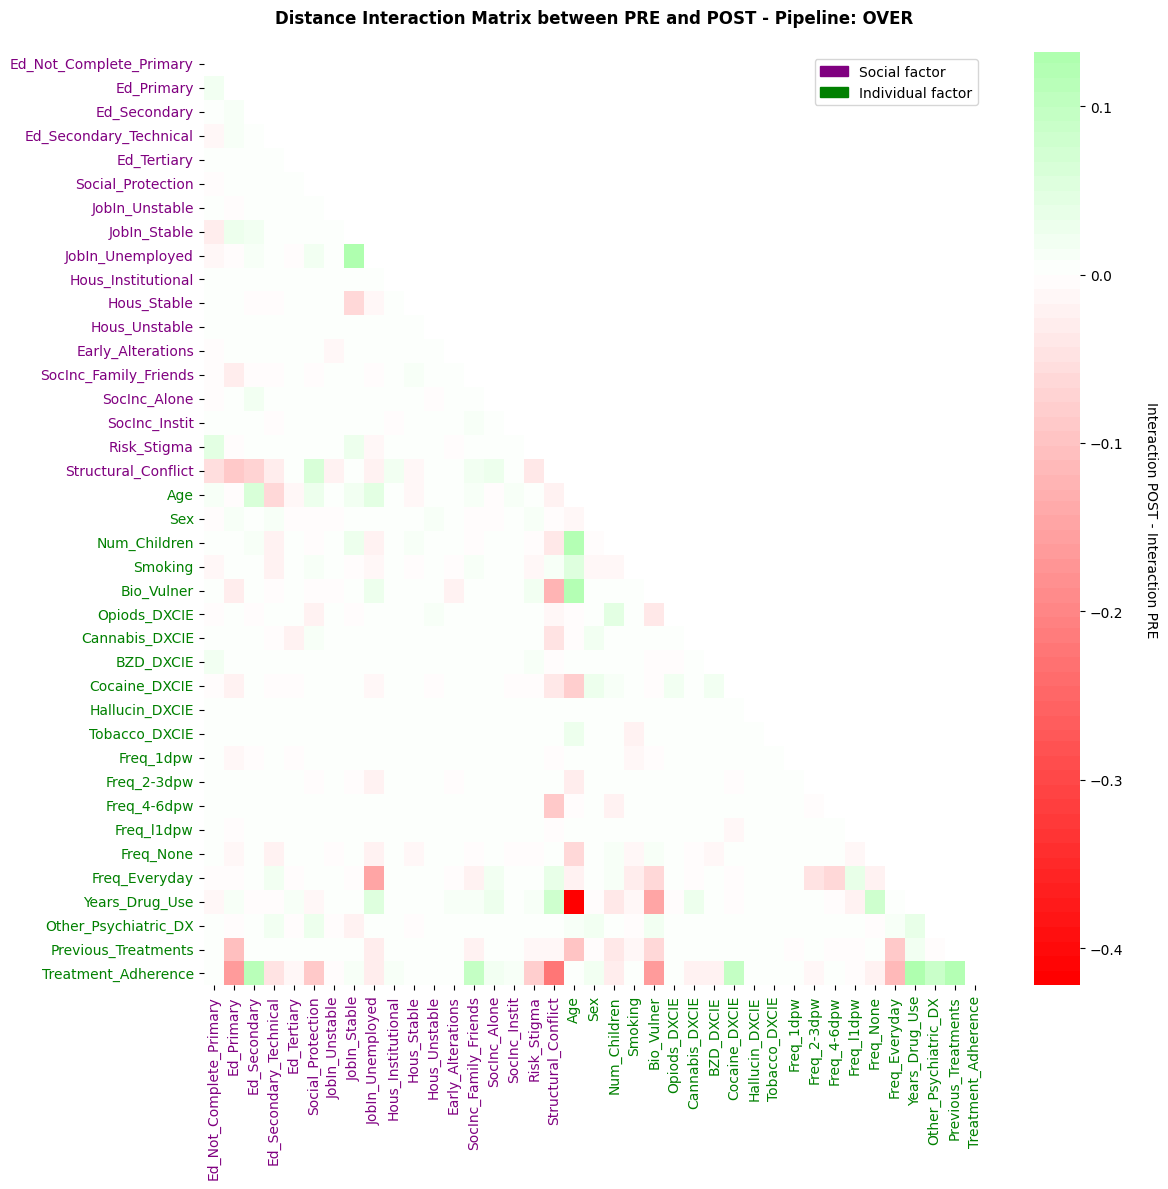

In [16]:
plot_distance_heatmap(dist_matrix, attribute_names, soc_var_names, method_name)

#### Excel Differences Sorted

In [ ]:
# Define tolerance
tolerance = np.median(np.abs(dist_matrix))  # Use the median of the absolute values for tolerance

# Create a DataFrame to hold the interactions
interactions = []

# Iterate over the matrix to extract interactions above the tolerance
for i in range(1, dist_matrix.shape[0]):
    for j in range(i):  # Lower triangle exclduing diagonal
        if abs(dist_matrix[i, j]) > tolerance: 
            var1 = attribute_names[i]
            var2 = attribute_names[j]
            if var1 in soc_var_names and var2 in soc_var_names:
                inter_type = 'Social'
            elif var1 in ind_var_names and var2 in ind_var_names:
                inter_type = 'Individual'
            else:
                inter_type = 'Mixed'
            interactions.append({
                'Variable 1': var1, 
                'Variable 2': var2,
                'SHAP Inter Variation PRE-POST': dist_matrix[i, j],
                'Interaction Type': inter_type
            })

# Convert the list of dictionaries to a DataFrame
interactions_df = pd.DataFrame(interactions)

sorted_interactions_df = interactions_df.reindex(
    interactions_df['SHAP Inter Variation PRE-POST'].abs().sort_values(ascending=False).index)

# Export to Excel
sorted_interactions_df.to_excel(f'./results/pre_post_inter_diff/inter_variation_{method_name}.xlsx', index=False)

print("Excel file has been created.")